In [1]:
get_ipython().run_line_magic('load_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')


In [2]:
import os
import sys
if 'Experiments' in os.getcwd():
	os.chdir('..')
	sys.path.insert(0,os.getcwd())
print(os.getcwd())
print(sys.path[0])

/export/home/enfita/Code/CST_official_github_repo
/export/home/enfita/Code/CST_official_github_repo


In [3]:
import matplotlib.pyplot as plt
from lib.CST.T_datacls import T_data
import numpy as np

import time

INFO:numexpr.utils:Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


/export/home/enfita/Code/CST_official_github_repo/lib/methods/mSTreg/topology/topology.py:74: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def vec_to_adj(vec):


In [4]:
def plot_time_vs_alpha(times_dict, alpha_ls, use_error_bars=True,
					   title='Average Time vs. Alpha for Different (n, d) Pairs',
					   log_scale=False, show=True):
	# Calculate mean and standard deviation for each (n, d) pair at each alpha value
	mean_times = {}
	std_times = {}
	for n, d in times_dict.keys():
		mean_times[(n, d)] = np.mean(times_dict[(n, d)], axis=1)
		std_times[(n, d)] = np.std(times_dict[(n, d)], axis=1)

	# Create a color map with enough unique colors for the (n, d) pairs
	num_pairs = len(times_dict)
	color_map = plt.get_cmap('tab10')

	# Plot the lines
	fig, ax = plt.subplots(figsize=(10, 6))

	for i, (n, d) in enumerate(mean_times.keys()):
		alpha_values = alpha_ls
		mean_values = mean_times[(n, d)]
		std_values = std_times[(n, d)]
		color = color_map(i % num_pairs)  # Cycle through the color map

		ax.plot(alpha_values, mean_values, label=f'n={n}, d={d}', color=color)

		if not use_error_bars:
			ax.fill_between(alpha_values, mean_values - std_values, mean_values + std_values, alpha=0.2, color=color)
		else:
			ax.errorbar(alpha_values, mean_values, yerr=std_values, fmt='.', markersize=4, capsize=3, color=color)

	ax.set_xlabel('Alpha')
	ax.set_ylabel('Average Time (in seconds)')
	ax.set_title(title)
	ax.set_xticks(alpha_ls)
	if log_scale:
		ax.set_yscale('log')

	ax.legend()

	if show:
		plt.show()


def plot_time_vs_n(times_dict, alpha_ls, use_error_bars=True,
				   title='Average Time vs. n for Different (alpha, d) Pairs',
				   log_scale=False, show=True):
	# Calculate mean and standard deviation for each (n, d) pair at each alpha value

	alpha_values = alpha_ls
	n_values = list(sorted(set(n for n, _ in times_dict.keys() if n > 10)))  # Extract unique n values
	d_values = list(sorted(set(d for _, d in times_dict.keys())))  # Extract unique d values

	mean_times = {}
	std_times = {}
	for n, d in times_dict.keys():
		if n == 10:
			continue
		mean_times[(n, d)] = np.mean(times_dict[(n, d)], axis=1)
		std_times[(n, d)] = np.std(times_dict[(n, d)], axis=1)

	mean_times_alpha = {(alpha, d): np.zeros(len(n_values)) for alpha in alpha_values for d in d_values}
	std_times_alpha = {(alpha, d): np.zeros(len(n_values)) for alpha in alpha_values for d in d_values}
	for idx_alpha, alpha in enumerate(alpha_ls):
		for d in d_values:
			for idx_n, n in enumerate(n_values):
				if n == 10:
					continue
				mean_times_alpha[(alpha, d)][idx_n] = mean_times[(n, d)][idx_alpha]
				std_times_alpha[(alpha, d)][idx_n] = std_times[(n, d)][idx_alpha]

	# Create a color map with enough unique colors for the (alpha, d) pairs
	num_pairs = len(mean_times_alpha)
	color_map = plt.get_cmap('tab20')

	# Plot the lines
	fig, ax = plt.subplots(figsize=(10, 6))

	for i, (alpha, d) in enumerate(mean_times_alpha.keys()):
		mean_values = mean_times_alpha[(alpha, d)]
		std_values = std_times_alpha[(alpha, d)]
		color = color_map(i % num_pairs)  # Cycle through the color map

		ax.plot(n_values, mean_values, label=f'alpha={alpha}, d={d}', color=color)

		if not use_error_bars:
			ax.fill_between(n_values, mean_values - std_values, mean_values + std_values, alpha=0.2, color=color)
		else:
			ax.errorbar(n_values, mean_values, yerr=std_values, fmt='.', markersize=4, capsize=3, color=color)

	ax.set_xlabel('n')
	ax.set_ylabel('Average Time (in seconds)')
	ax.set_title(title)
	ax.set_xticks(n_values)
	ax.set_xticklabels(n_values)
	if log_scale:
		ax.set_yscale('log')

	ax.legend()
	if show:
		plt.show()

In [5]:
'''Warm up'''
P=np.random.normal(size=(500,2))
tdata_calentament = T_data(P, verbose=False)
demands=np.array([1]+[-1/(len(P)-1)]*(len(P)-1))
tdata_calentament.compute_BCST(alpha=0.5, demands=None, maxiter_mSTreg=5, maxfreq_mSTreg=5,
							   init_topo='mST', filter_BP_from_solution=False)

## Setting parameters

In [6]:
d_ls=list(reversed([2,10]))
n_ls=list(reversed([100,1000,5000,10000]))
alpha_ls=list(reversed([0,0.2,0.4,0.6,0.8,1]))
num_instance_problems=5

save=False
verbose=True
mST_fromknn=True
compute_CST_time=True
# alpha_ls=[0,0.75]

maxiter_mSTreg=20
maxfreq_mSTreg=3
merging_criterium='tryall'
order_criterium='closest'
criterium_BP_position_update='median'#'median'
init_topo='mST'

### Compute times

In [7]:
tdata_ls={}
D_dict={}
np.random.seed(0)

times_dict_CST={}
times_dict_BCST={}
for n in n_ls:
	for d in d_ls:
		times_dict_BCST[(n,d)]=np.zeros((len(alpha_ls),num_instance_problems))
		times_dict_CST[(n,d)]=np.zeros((len(alpha_ls),num_instance_problems))
		for instance_problem in range(num_instance_problems):

			np.random.seed(instance_problem)
			# sample points uniformly from square between 0 and 1 with d dimensions
			P=np.random.uniform(size=(n,d))
			tdata=T_data(P,verbose=False)
			tdata.minimum_spanning_tree(from_knn=True)
			for idx_alpha,alpha in enumerate(alpha_ls):
				print('n={}, d={}, instance_problem={}, alpha={}'.format(n,d,instance_problem,alpha))
				s_time=time.time()
				tdata.compute_BCST(alpha=alpha, maxiter_mSTreg=maxiter_mSTreg, maxfreq_mSTreg=maxfreq_mSTreg, return_topo_CST=False,
												 merging_criterium=merging_criterium, order_criterium=order_criterium,
												 criterium_BP_position_update=criterium_BP_position_update, init_topo=init_topo,
												 compute_CST_each_iter=True,mST_fromknn=mST_fromknn,filter_BP_from_solution=False)

				BCST_time=time.time()-s_time
				times_dict_BCST[(n,d)][idx_alpha,instance_problem]=BCST_time
				print('\t BCST_time={}'.format(BCST_time))

				if compute_CST_time:
					s_time=time.time()
					tdata.compute_BCST(alpha=alpha, maxiter_mSTreg=maxiter_mSTreg, maxfreq_mSTreg=maxfreq_mSTreg,
									   return_topo_CST=True,
									   merging_criterium=merging_criterium, order_criterium=order_criterium,
									   criterium_BP_position_update=criterium_BP_position_update, init_topo=init_topo,
									   compute_CST_each_iter=True, mST_fromknn=mST_fromknn,filter_BP_from_solution=False)
					CST_time=time.time()-s_time
					times_dict_CST[(n,d)][idx_alpha,instance_problem]=CST_time
					print('\t CST_time={}'.format(CST_time))



n=10000, d=10, instance_problem=0, alpha=1
	 BCST_time=307.59669613838196
	 CST_time=6968.076641082764
n=10000, d=10, instance_problem=0, alpha=0.8
	 BCST_time=316.6237323284149
	 CST_time=1067.9963524341583
n=10000, d=10, instance_problem=0, alpha=0.6
	 BCST_time=260.86604499816895
	 CST_time=464.9229664802551
n=10000, d=10, instance_problem=0, alpha=0.4
	 BCST_time=226.83352637290955
	 CST_time=412.76379346847534
n=10000, d=10, instance_problem=0, alpha=0.2
	 BCST_time=214.11781072616577
	 CST_time=383.11739325523376
n=10000, d=10, instance_problem=0, alpha=0
	 BCST_time=213.5405249595642
	 CST_time=387.0228490829468
n=10000, d=10, instance_problem=1, alpha=1
	 BCST_time=297.8083517551422
	 CST_time=6713.029636144638
n=10000, d=10, instance_problem=1, alpha=0.8
	 BCST_time=319.513552904129
	 CST_time=1129.1620717048645
n=10000, d=10, instance_problem=1, alpha=0.6
	 BCST_time=256.91544914245605
	 CST_time=466.7193195819855
n=10000, d=10, instance_problem=1, alpha=0.4
	 BCST_time=239.6

## Plot figures

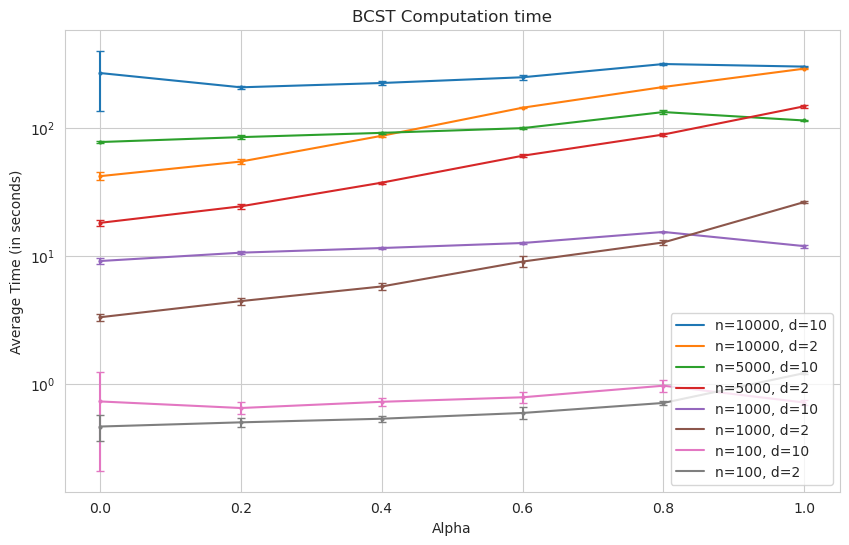

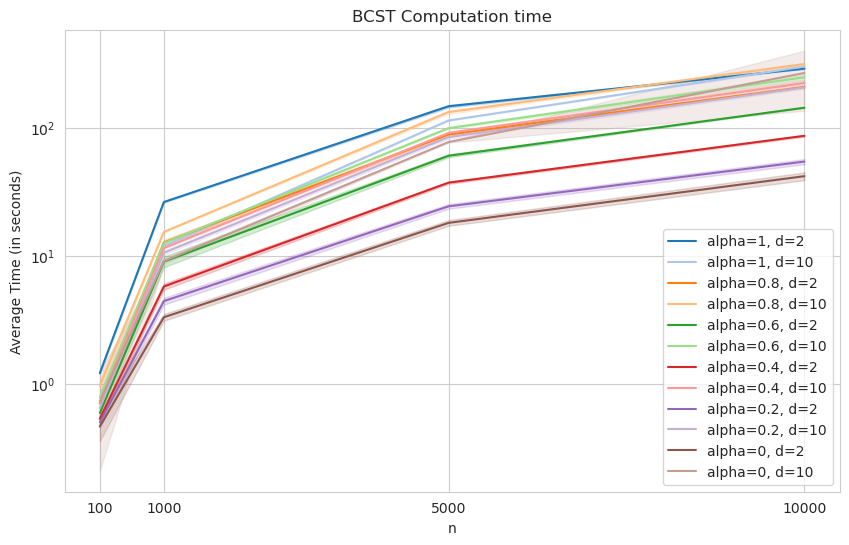

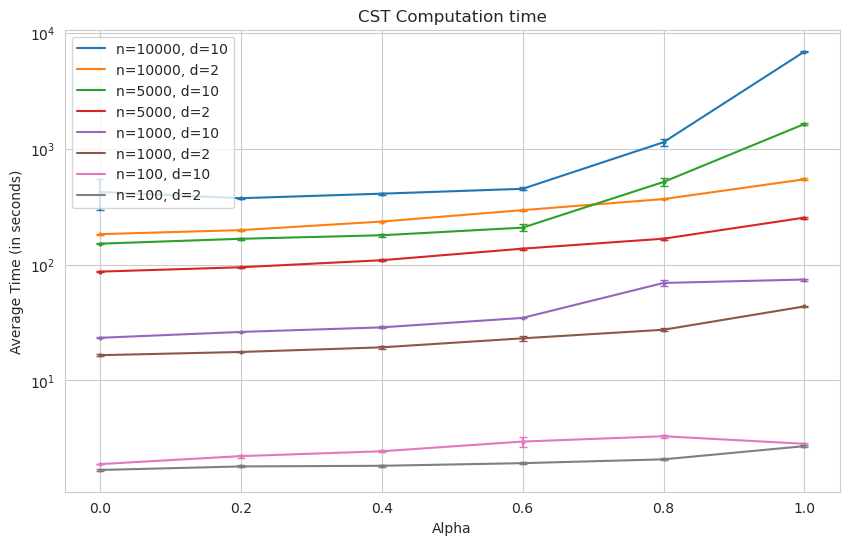

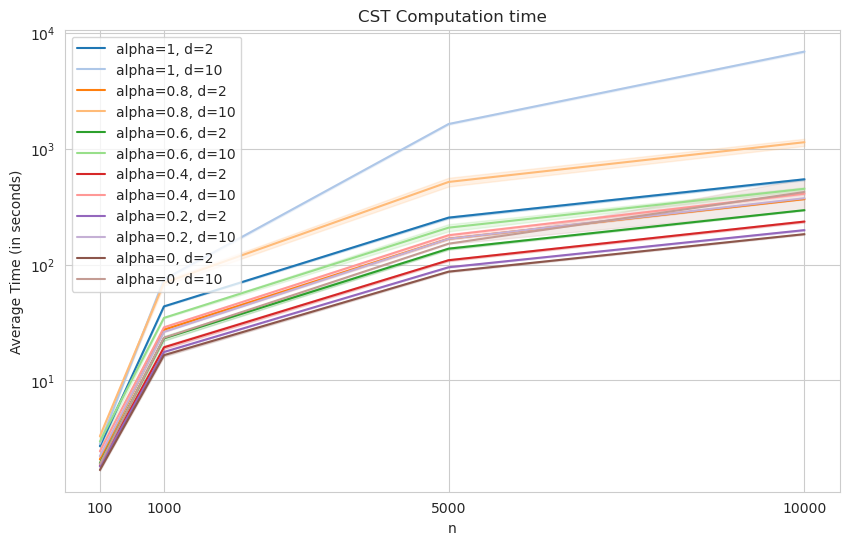

In [8]:

if save:
	folder='Figures/time_complexity/'
	os.makedirs(folder,True)


plot_time_vs_alpha(times_dict_BCST, alpha_ls, use_error_bars=True, title='BCST Computation time',
                   log_scale=True,show=not save)
# plot_time_vs_alpha(times_dict_BCST, alpha_ls, use_error_bars=True, title='CST Time')
if save:
	plt.savefig(folder+'BCST_time_vs_alpha.png',dpi=200)
	plt.show()
# Example usage:
# Assuming you have 'times_dict_BCST' and 'alpha_ls' defined
plot_time_vs_n(times_dict_BCST, alpha_ls, use_error_bars=False, title='BCST Computation time', log_scale=True,
               show=not save)
if save:
	plt.savefig(folder+'BCST_time_vs_n.png',dpi=200)
	plt.show()


if compute_CST_time:
	plot_time_vs_alpha(times_dict_CST, alpha_ls, use_error_bars=True, title='CST Computation time',
	                   log_scale=True,show=not save)
	# plot_time_vs_alpha(times_dict_BCST, alpha_ls, use_error_bars=True, title='CST Time')
	if save:
		plt.savefig(folder+'CST_time_vs_alpha.png',dpi=200)
		plt.show()
	# Example usage:
	# Assuming you have 'times_dict_BCST' and 'alpha_ls' defined
	plot_time_vs_n(times_dict_CST, alpha_ls, use_error_bars=False, title='CST Computation time', log_scale=True,
	               show=not save)


	if save:
		plt.savefig(folder + 'CST_time_vs_n.png', dpi=200)
		plt.show()